# Importações

In [181]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

In [182]:
# Criação do dataframe 
df_censo = pd.read_csv('database_dropout.csv')

df_censo.drop(columns=['NO_REGIAO', 'SG_UF','CO_MUNICIPIO', 'NO_MUNICIPIO', 'CO_ENTIDADE','NO_ENTIDADE', 'NO_CATEGORIA','NO_DEPENDENCIA'], inplace=True)

# Informações do dataframe
df_censo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130129 entries, 0 to 130128
Data columns (total 44 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   TX_APROV_FUND                   130129 non-null  float64
 1   TX_APROV_MED                    130129 non-null  float64
 2   TX_REPR_FUND                    130129 non-null  float64
 3   TX_REPR_MED                     130129 non-null  float64
 4   TX_DIS_FUND                     130129 non-null  float64
 5   TX_DIS_MED                      130129 non-null  float64
 6   M_ATU_FUND                      130129 non-null  float64
 7   M_ATU_MED                       130129 non-null  float64
 8   TX_DSU_FUND                     130129 non-null  float64
 9   TX_DSU_MED                      130129 non-null  float64
 10  M_HAU_FUND                      130129 non-null  float64
 11  M_HAU_MED                       130129 non-null  float64
 12  IN_AGUA_INEXISTE

# Funções

In [183]:
def tratar_outliers_iqr(df, colunas, estrategia='remover', valor_substituicao='mediana', mostrar_stats=True):
    """
    Trata outliers usando o método IQR com diferentes estratégias.
    
    Parâmetros:
    -----------
    df : pandas.DataFrame
        DataFrame contendo os dados
    colunas : list
        Lista de colunas para tratar outliers
    estrategia : str, opcional (default='remover')
        Estratégia para tratar outliers:
        - 'remover': remove registros com outliers
        - 'substituir': substitui outliers por um valor específico
    valor_substituicao : str ou float, opcional (default='mediana')
        Valor para substituir outliers quando estrategia='substituir':
        - 'mediana': usa a mediana da coluna
        - 'media': usa a média da coluna
        - 'limite': usa os limites do IQR
        - float: usa um valor específico
    mostrar_stats : bool, opcional (default=True)
        Se True, mostra estatísticas detalhadas do processo
        
    Retorna:
    --------
    pandas.DataFrame
        DataFrame com outliers tratados
    dict
        Dicionário com estatísticas do tratamento
    """
    
    # Criar cópia do DataFrame para não modificar o original
    df_tratado = df.copy()
    
    # Guardar quantidade inicial de registros
    total_inicial = len(df_tratado)
    if mostrar_stats:
        print("1. Total inicial:", total_inicial)
        print("\n2. Colunas sendo analisadas:")
        print(colunas)
    
    # Criar DataFrame para armazenar máscaras de outliers
    outliers_mask = pd.DataFrame(index=df_tratado.index)
    
    # Estatísticas para retorno
    stats = {
        'total_inicial': total_inicial,
        'outliers_por_coluna': {},
        'limites': {},
        'valores_substituicao': {}
    }
    
    # Processar cada coluna
    if mostrar_stats:
        print("\n3. Análise de outliers por coluna:")
    
    total_substituicoes = 0
    
    for col in colunas:
        # Calcular Q1, Q3 e IQR
        Q1 = df_tratado[col].quantile(0.25)
        Q3 = df_tratado[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Definir limites
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        
        # Identificar outliers
        mask = (df_tratado[col] < limite_inferior) | (df_tratado[col] > limite_superior)
        outliers_mask[col] = mask
        
        # Guardar estatísticas
        n_outliers = mask.sum()
        stats['outliers_por_coluna'][col] = n_outliers
        stats['limites'][col] = {
            'Q1': Q1, 
            'Q3': Q3, 
            'IQR': IQR, 
            'limite_inferior': limite_inferior, 
            'limite_superior': limite_superior
        }
        
        if mostrar_stats:
            print(f"\nColuna: {col}")
            print(f"Q1: {Q1:.2f}")
            print(f"Q3: {Q3:.2f}")
            print(f"IQR: {IQR:.2f}")
            print(f"Limite inferior: {limite_inferior:.2f}")
            print(f"Limite superior: {limite_superior:.2f}")
            print(f"Número de outliers: {n_outliers}")
            print(f"Percentual de outliers: {(n_outliers/total_inicial)*100:.2f}%")
        
        # Substituir outliers se necessário
        if estrategia == 'substituir':
            if valor_substituicao == 'mediana':
                valor = df_tratado[col].median()
                stats['valores_substituicao'][col] = {'tipo': 'mediana', 'valor': valor}
            elif valor_substituicao == 'media':
                valor = df_tratado[col].mean()
                stats['valores_substituicao'][col] = {'tipo': 'media', 'valor': valor}
            elif valor_substituicao == 'limite':
                df_tratado.loc[df_tratado[col] < limite_inferior, col] = limite_inferior
                df_tratado.loc[df_tratado[col] > limite_superior, col] = limite_superior
                stats['valores_substituicao'][col] = {
                    'tipo': 'limite',
                    'inferior': limite_inferior,
                    'superior': limite_superior
                }
                continue
            else:
                valor = float(valor_substituicao)
                stats['valores_substituicao'][col] = {'tipo': 'valor_fixo', 'valor': valor}
            
            df_tratado.loc[mask, col] = valor
            total_substituicoes += n_outliers
    
    # Tratar registros com outliers
    if estrategia == 'remover':
        registros_com_outliers = outliers_mask.any(axis=1)
        df_tratado = df_tratado[~registros_com_outliers]
        
        if mostrar_stats:
            total_final = len(df_tratado)
            registros_removidos = total_inicial - total_final
            percentual_removido = (registros_removidos / total_inicial) * 100
            
            print("\n4. Resultado final (Remoção):")
            print(f"Quantidade inicial de registros: {total_inicial:,}")
            print(f"Registros removidos: {registros_removidos:,}")
            print(f"Quantidade final de registros: {total_final:,}")
            print(f"Percentual de registros removidos: {percentual_removido:.2f}%")
            
            stats.update({
                'total_final': total_final,
                'registros_removidos': registros_removidos,
                'percentual_removido': percentual_removido
            })
    else:  # estrategia == 'substituir'
        if mostrar_stats:
            print(f"\n4. Resultado final (Substituição):")
            print(f"Quantidade de registros: {total_inicial:,}")
            print(f"Total de valores substituídos: {total_substituicoes:,}")
            print(f"Percentual de valores substituídos: {(total_substituicoes/(total_inicial*len(colunas)))*100:.2f}%")
            print(f"\nMétodo de substituição: {valor_substituicao}")
            
            stats.update({
                'total_substituicoes': total_substituicoes,
                'percentual_substituido': (total_substituicoes/(total_inicial*len(colunas)))*100
            })
    
    return df_tratado, stats

In [184]:
def exibe_graficos_coluna(df, coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plotar histograma
    sns.histplot(data=df, x=coluna, ax=ax1)
    ax1.set_title(f'Histograma - {coluna}')
    ax1.tick_params(axis='x', rotation=45)
    
    # Plotar boxplot
    sns.boxplot(data=df, y=coluna, ax=ax2)
    ax2.set_title(f'Boxplot - {coluna}')
    
    plt.tight_layout()
    plt.show()


def obter_outliers(df, coluna):
    """
    Retorna uma tupla com os outliers de uma coluna, seu limite superior e inferior utilizando IQR.
    """
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    
    outliers = df[(df[coluna] < (Q1 - 1.5 * IQR)) | (df[coluna] > (Q3 + 1.5 * IQR))][coluna]
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    return outliers, limite_inferior, limite_superior



def analise_outliers(df):
    # Selecionar apenas colunas numéricas
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    # Criar um dataframe para armazenar os resultados
    outliers_summary = pd.DataFrame(columns=['Coluna', 'Total_Outliers', 'Percentual_Outliers', 'Limite_Inferior', 'Limite_Superior', 'Max_Real'])
    
    for col in numeric_cols:
        outliers, limite_inferior, limite_superior = obter_outliers(df, col)
        total_outliers = len(outliers)
        percentual_outliers = (total_outliers / len(df)) * 100
        
        # Calcular limites usando z-score
        media = df[col].mean()
        desvio_padrao = df[col].std()
        
        # Obter valor máximo real
        max_real = df[col].max()
        # Usar o menor valor entre o limite calculado e o máximo real
        limite_superior = min(limite_superior, max_real)
        
        # Adicionar resultados ao dataframe
        outliers_summary.loc[len(outliers_summary)] = [
            col,
            total_outliers,
            round(percentual_outliers, 2),
            round(limite_inferior, 2),
            round(limite_superior, 2),
            max_real
        ]
    
    # Ordenar por percentual de outliers
    outliers_summary = outliers_summary.sort_values('Percentual_Outliers', ascending=False)
    
    # Mostrar comparação com describe
    # print("Comparação com estatísticas descritivas:")
    # print("\nDescrição do DataFrame:")
    # print(df[numeric_cols].describe())
    
    return outliers_summary

# EDA

In [185]:
# Copiar DF para DF EDA
df_censo_eda = df_censo.copy()

# Converter para booleano
df_censo_eda['IN_INTERNET'] = df_censo_eda['IN_INTERNET'].astype(bool)
df_censo_eda['IN_SALA_PROFESSOR'] = df_censo_eda['IN_SALA_PROFESSOR'].astype(bool)
df_censo_eda['IN_AGUA_INEXISTENTE'] = df_censo_eda['IN_AGUA_INEXISTENTE'].astype(bool)
df_censo_eda['IN_ENERGIA_INEXISTENTE'] = df_censo_eda['IN_ENERGIA_INEXISTENTE'].astype(bool)
df_censo_eda['IN_ESGOTO_INEXISTENTE'] = df_censo_eda['IN_ESGOTO_INEXISTENTE'].astype(bool)
df_censo_eda['IN_AUDITORIO'] = df_censo_eda['IN_AUDITORIO'].astype(bool)
df_censo_eda['IN_BANHEIRO'] = df_censo_eda['IN_BANHEIRO'].astype(bool)
df_censo_eda['IN_BIBLIOTECA'] = df_censo_eda['IN_BIBLIOTECA'].astype(bool)
df_censo_eda['IN_LABORATORIO_INFORMATICA'] = df_censo_eda['IN_LABORATORIO_INFORMATICA'].astype(bool)
df_censo_eda['IN_PARQUE_INFANTIL'] = df_censo_eda['IN_PARQUE_INFANTIL'].astype(bool)
df_censo_eda['IN_PISCINA'] = df_censo_eda['IN_PISCINA'].astype(bool)
df_censo_eda['IN_REFEITORIO'] = df_censo_eda['IN_REFEITORIO'].astype(bool)
df_censo_eda['IN_SALA_LEITURA'] = df_censo_eda['IN_SALA_LEITURA'].astype(bool)
df_censo_eda['IN_SALA_PROFESSOR'] = df_censo_eda['IN_SALA_PROFESSOR'].astype(bool)
df_censo_eda['IN_ACESSIBILIDADE_INEXISTENTE'] = df_censo_eda['IN_ACESSIBILIDADE_INEXISTENTE'].astype(bool)
df_censo_eda['IN_QUADRA_ESPORTES'] = df_censo_eda['IN_QUADRA_ESPORTES'].astype(bool)

# converte  inteiros
df_censo_eda['IN_TRATAMENTO_LIXO_INEXISTENTE'] = df_censo_eda['IN_TRATAMENTO_LIXO_INEXISTENTE'].astype(int)
df_censo_eda['QT_SALAS_UTILIZADAS'] = df_censo_eda['QT_SALAS_UTILIZADAS'].astype(int)
df_censo_eda['QT_SALAS_UTILIZA_CLIMATIZADAS'] = df_censo_eda['QT_SALAS_UTILIZA_CLIMATIZADAS'].astype(int)
df_censo_eda['QT_SALAS_UTILIZADAS_ACESSIVEIS'] = df_censo_eda['QT_SALAS_UTILIZADAS_ACESSIVEIS'].astype(int)
df_censo_eda['TP_REDE_LOCAL'] = df_censo_eda['TP_REDE_LOCAL'].astype(int)
df_censo_eda['QT_PROF_ADMINISTRATIVOS'] = df_censo_eda['QT_PROF_ADMINISTRATIVOS'].astype(int)
df_censo_eda['QT_PROF_SERVICOS_GERAIS'] = df_censo_eda['QT_PROF_SERVICOS_GERAIS'].astype(int)
df_censo_eda['QT_PROF_BIBLIOTECARIO'] = df_censo_eda['QT_PROF_BIBLIOTECARIO'].astype(int)
df_censo_eda['QT_PROF_SAUDE'] = df_censo_eda['QT_PROF_SAUDE'].astype(int)
df_censo_eda['QT_PROF_SEGURANCA'] = df_censo_eda['QT_PROF_SEGURANCA'].astype(int)
df_censo_eda['QT_PROF_GESTAO'] = df_censo_eda['QT_PROF_GESTAO'].astype(int)
df_censo_eda['QT_SALAS_UTILIZADAS'] = df_censo_eda['QT_SALAS_UTILIZADAS'].astype(int)
df_censo_eda['QT_SALAS_UTILIZA_CLIMATIZADAS'] = df_censo_eda['QT_SALAS_UTILIZA_CLIMATIZADAS'].astype(int)
df_censo_eda['QT_SALAS_UTILIZADAS_ACESSIVEIS'] = df_censo_eda['QT_SALAS_UTILIZADAS_ACESSIVEIS'].astype(int)
df_censo_eda['QT_PROF_ALIMENTACAO'] = df_censo_eda['QT_PROF_ALIMENTACAO'].astype(int)

# convertendo dados categoricos
encoder = OrdinalEncoder(categories=[['Baixa','Moderada','Alta']])
df_censo_eda['TX_EV_TOT'] = encoder.fit_transform(df_censo_eda[['TX_EV_TOT']])
df_censo_eda['TX_EV_TOT'] = df_censo_eda['TX_EV_TOT'].astype(int)

# Visualização de dados

In [186]:
# Medidas estatisticas do dataframe
df_censo_eda.describe()

,TX_APROV_FUND,TX_APROV_MED,TX_REPR_FUND,TX_REPR_MED,TX_DIS_FUND,TX_DIS_MED,M_ATU_FUND,M_ATU_MED,TX_DSU_FUND,TX_DSU_MED,...,QT_PROF_BIBLIOTECARIO,QT_PROF_SAUDE,QT_PROF_ALIMENTACAO,QT_PROF_SEGURANCA,QT_PROF_GESTAO,QT_TUR_FUND,QT_TUR_MED,PIB_MUN,PIB_PC_MUN,TX_EV_TOT
count,130129.000000,130129.000000,130129.000000,130129.000000,130129.000000,130129.000000,130129.000000,130129.000000,130129.000000,130129.000000,...,130129.000000,130129.000000,130129.000000,130129.000000,130129.000000,130129.000000,130129.000000,1.301290e+05,130129.000000,130129.000000
mean,96.413265,91.525948,2.233555,3.470273,14.206139,26.584138,18.203997,6.081757,81.231129,95.013903,...,24.294300,151.733157,28.028426,96.060632,12.949327,8.911419,1.980619,3.799957e+07,33965.719080,0.157090
std,7.268577,8.574392,5.562855,4.793156,14.482872,16.363533,9.038688,12.243515,29.680020,8.916247,...,1457.577143,3668.284821,1538.574344,2913.975963,1045.348142,8.056948,5.264287,1.365195e+08,39285.631321,0.481401
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.805110e+04,5407.700000,0.000000
25%,96.100000,87.900000,0.000000,0.200000,3.500000,14.000000,12.000000,0.000000,75.000000,93.600000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,3.018507e+05,12906.300000,0.000000
50%,99.400000,94.100000,0.000000,1.800000,10.000000,24.400000,18.800000,0.000000,97.500000,98.300000,...,0.000000,0.000000,1.000000,0.000000,0.000000,7.000000,0.000000,1.181478e+06,23907.900000,0.000000
75%,100.000000,97.900000,1.800000,4.700000,20.400000,37.200000,24.800000,0.000000,100.000000,100.000000,...,0.000000,0.000000,2.000000,0.000000,1.000000,12.000000,0.000000,1.006380e+07,44705.300000,0.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,162.000000,205.700000,100.000000,100.000000,...,88888.000000,88888.000000,88888.000000,88888.000000,88888.000000,167.000000,164.000000,8.289806e+08,920834.000000,2.000000


In [187]:
# # Exibe gráficos de todas as colunas não boleanas
# df = df_censo_eda.select_dtypes(exclude=['bool'])
# print(f'Visualizando gráficos de {len(df.columns)} colunas')
# for col in df.columns:
#     # Criar figura com dois subplots lado a lado
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
#     # Plotar histograma
#     sns.histplot(data=df_censo_eda, x=col, ax=ax1)
#     ax1.set_title(f'Histograma - {col}')
#     ax1.tick_params(axis='x', rotation=45)
    
#     # Plotar boxplot
#     sns.boxplot(data=df_censo_eda, y=col, ax=ax2)
#     ax2.set_title(f'Boxplot - {col}')
    
#     plt.tight_layout()
#     plt.show()

# Outliers

In [188]:
# Detectar valores ausentes
print(f'Total de valores ausentes: {df_censo_eda.isna().sum().sum()}')

Total de valores ausentes: 0



Resumo dos Outliers por Coluna:
--------------------------------
                            Coluna  Total_Outliers  Percentual_Outliers  \
19           QT_PROF_BIBLIOTECARIO           32337                24.85   
16                   TP_REDE_LOCAL           30176                23.19   
25                      QT_TUR_MED           29143                22.40   
7                        M_ATU_MED           29143                22.40   
22               QT_PROF_SEGURANCA           23171                17.81   
15  QT_SALAS_UTILIZADAS_ACESSIVEIS           21927                16.85   
26                         PIB_MUN           20049                15.41   
2                     TX_REPR_FUND           19077                14.66   
0                    TX_APROV_FUND           14748                11.33   
8                      TX_DSU_FUND           14278                10.97   
28                       TX_EV_TOT           13979                10.74   
14   QT_SALAS_UTILIZA_CLIMATIZADAS

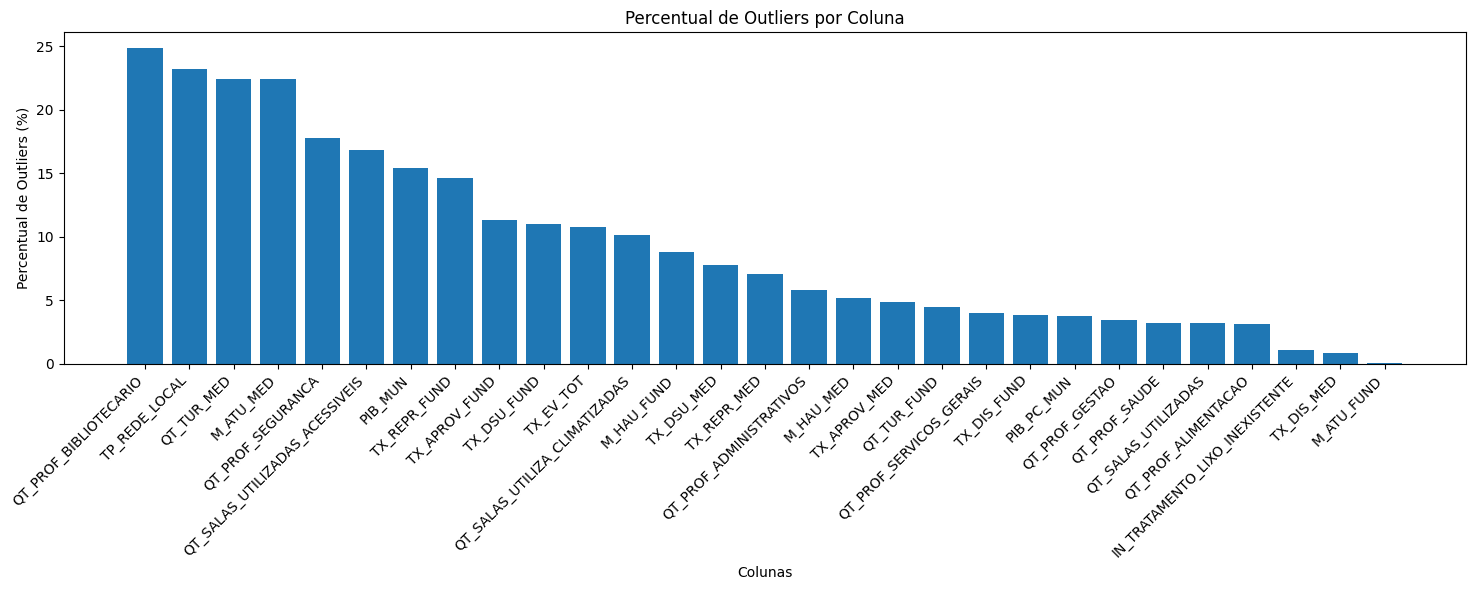

In [189]:
# Visualiza um panorama geral dos outliers de todas as colunas
resultado_outliers = analise_outliers(df_censo_eda)

# Exibir o resultado
print("\nResumo dos Outliers por Coluna:")
print("--------------------------------")
print(resultado_outliers)

# Criar um gráfico de barras para visualizar o percentual de outliers
plt.figure(figsize=(15, 6))
plt.bar(resultado_outliers['Coluna'], resultado_outliers['Percentual_Outliers'])
plt.xticks(rotation=45, ha='right')
plt.title('Percentual de Outliers por Coluna')
plt.xlabel('Colunas')
plt.ylabel('Percentual de Outliers (%)')
plt.tight_layout()
plt.show()

## Tratamento de outliers

### TP_REDE_LOCAL

23% dos registros da coluna de tipo de rede local são outliers com valor 9 (Não informado)
Então será alterado de 9 para 5 para manter a ordinalidade e tratar os outliers

In [190]:
# Verificar a quantidade inicial de registros com valor 9
registros_rede_local_9 = df_censo_eda[df_censo_eda['TP_REDE_LOCAL'] == 9]
qt_registros_rede_local_9 = len(registros_rede_local_9)

# Calcular o percentual em relação ao total
percentual = (qt_registros_rede_local_9 / len(df_censo_eda)) * 100

print("Quantidade inicial de registros com valor 9 em TP_REDE_LOCAL:", qt_registros_rede_local_9)
print(f"Percentual em relação ao total do dataset: {percentual:.2f}%")

# Altera todos os registros de tipo de rede local igual a 9 para 5
df_censo_eda.loc[df_censo_eda['TP_REDE_LOCAL'] == 9, 'TP_REDE_LOCAL'] = 5

# exibe_graficos_coluna(df_censo_eda, 'TP_REDE_LOCAL')

Quantidade inicial de registros com valor 9 em TP_REDE_LOCAL: 30176
Percentual em relação ao total do dataset: 23.19%


In [191]:
# Exibir o resultado
print("\nResumo dos Outliers por Coluna:")
print("--------------------------------")
print(analise_outliers(df_censo_eda))


Resumo dos Outliers por Coluna:
--------------------------------
                            Coluna  Total_Outliers  Percentual_Outliers  \
19           QT_PROF_BIBLIOTECARIO           32337                24.85   
25                      QT_TUR_MED           29143                22.40   
7                        M_ATU_MED           29143                22.40   
22               QT_PROF_SEGURANCA           23171                17.81   
15  QT_SALAS_UTILIZADAS_ACESSIVEIS           21927                16.85   
26                         PIB_MUN           20049                15.41   
2                     TX_REPR_FUND           19077                14.66   
0                    TX_APROV_FUND           14748                11.33   
8                      TX_DSU_FUND           14278                10.97   
28                       TX_EV_TOT           13979                10.74   
14   QT_SALAS_UTILIZA_CLIMATIZADAS           13212                10.15   
10                      M_HAU_FUND

### QT_PROF

todos os QT_prof devem ser substituídos pelo limite superior, pois quando há o preenchimento 88888 é pq está superior ao necessário

In [192]:
# Obter lista de nomes de colunas que começam com QT_PROF
qt_prof_cols = [col for col in df_censo_eda.columns if col.startswith('QT_PROF')]
for col in qt_prof_cols:
    registros_88888 = len(df_censo_eda[df_censo_eda[col] == 88888])
    print(f"Quantidade de registros na coluna {col} que é igual a 88888: {registros_88888:,}")

# Quantidade inicial de registros
total_registros = len(df_censo_eda)
# print(f"Quantidade total de registros: {total_registros:,}")

# Criar máscara para registros com 88888 em qualquer uma das colunas
registros_afetados = df_censo_eda[qt_prof_cols].eq(88888).any(axis=1)

# Contar registros afetados
total_afetados = registros_afetados.sum()
percentual = (total_afetados / total_registros) * 100

print(f"\nQuantidade de linhas com ao menos uma coluna igual a 88888: {total_afetados:,}")
print(f"Percentual do total: {percentual:.2f}%")



Quantidade de registros na coluna QT_PROF_ADMINISTRATIVOS que é igual a 88888: 292
Quantidade de registros na coluna QT_PROF_SERVICOS_GERAIS que é igual a 88888: 125
Quantidade de registros na coluna QT_PROF_BIBLIOTECARIO que é igual a 88888: 35
Quantidade de registros na coluna QT_PROF_SAUDE que é igual a 88888: 222
Quantidade de registros na coluna QT_PROF_ALIMENTACAO que é igual a 88888: 39
Quantidade de registros na coluna QT_PROF_SEGURANCA que é igual a 88888: 140
Quantidade de registros na coluna QT_PROF_GESTAO que é igual a 88888: 18

Quantidade de linhas com ao menos uma coluna igual a 88888: 815
Percentual do total: 0.63%


In [193]:
# Remover registros com 88888 em qualquer uma das colunas qt_prof_cols
df_censo_eda = df_censo_eda[~registros_afetados]

In [194]:
# Exibir o resultado
print("\nResumo dos Outliers por Coluna:")
print("--------------------------------")
print(analise_outliers(df_censo_eda))


Resumo dos Outliers por Coluna:
--------------------------------
                            Coluna  Total_Outliers  Percentual_Outliers  \
19           QT_PROF_BIBLIOTECARIO           32059                24.79   
25                      QT_TUR_MED           28920                22.36   
7                        M_ATU_MED           28920                22.36   
22               QT_PROF_SEGURANCA           22904                17.71   
15  QT_SALAS_UTILIZADAS_ACESSIVEIS           21782                16.84   
26                         PIB_MUN           19855                15.35   
2                     TX_REPR_FUND           18998                14.69   
0                    TX_APROV_FUND           14696                11.36   
8                      TX_DSU_FUND           14173                10.96   
28                       TX_EV_TOT           13932                10.77   
14   QT_SALAS_UTILIZA_CLIMATIZADAS           13104                10.13   
10                      M_HAU_FUND

In [195]:
# Exibe gráficos de todas as colunas qt_prof_cols
# for col in qt_prof_cols:
#     exibe_graficos_coluna(df_censo_eda, col)

Já que não surtiu efeito removendo 88888, vamos substituir pela mediana

In [196]:
# Criar dataframe sem os outliers
df_sem_outliers, stats_remocao = tratar_outliers_iqr(
    df_censo_eda, 
    qt_prof_cols,
    estrategia='substituir',
    valor_substituicao='mediana',
    mostrar_stats=True
)

1. Total inicial: 129314

2. Colunas sendo analisadas:
['QT_PROF_ADMINISTRATIVOS', 'QT_PROF_SERVICOS_GERAIS', 'QT_PROF_BIBLIOTECARIO', 'QT_PROF_SAUDE', 'QT_PROF_ALIMENTACAO', 'QT_PROF_SEGURANCA', 'QT_PROF_GESTAO']

3. Análise de outliers por coluna:

Coluna: QT_PROF_ADMINISTRATIVOS
Q1: 0.00
Q3: 2.00
IQR: 2.00
Limite inferior: -3.00
Limite superior: 5.00
Número de outliers: 7289
Percentual de outliers: 5.64%

Coluna: QT_PROF_SERVICOS_GERAIS
Q1: 1.00
Q3: 5.00
IQR: 4.00
Limite inferior: -5.00
Limite superior: 11.00
Número de outliers: 5055
Percentual de outliers: 3.91%

Coluna: QT_PROF_BIBLIOTECARIO
Q1: 0.00
Q3: 0.00
IQR: 0.00
Limite inferior: 0.00
Limite superior: 0.00
Número de outliers: 32059
Percentual de outliers: 24.79%

Coluna: QT_PROF_SAUDE
Q1: 0.00
Q3: 0.00
IQR: 0.00
Limite inferior: 0.00
Limite superior: 0.00
Número de outliers: 3890
Percentual de outliers: 3.01%

Coluna: QT_PROF_ALIMENTACAO
Q1: 0.00
Q3: 2.00
IQR: 2.00
Limite inferior: -3.00
Limite superior: 5.00
Número de outli

In [197]:
# Aplica as remoções
df_censo_eda = df_sem_outliers

In [198]:
# Exibir o resultado
print("\nResumo dos Outliers por Coluna:")
print("--------------------------------")
print(analise_outliers(df_censo_eda))


Resumo dos Outliers por Coluna:
--------------------------------
                            Coluna  Total_Outliers  Percentual_Outliers  \
7                        M_ATU_MED           28920                22.36   
25                      QT_TUR_MED           28920                22.36   
15  QT_SALAS_UTILIZADAS_ACESSIVEIS           21782                16.84   
26                         PIB_MUN           19855                15.35   
2                     TX_REPR_FUND           18998                14.69   
0                    TX_APROV_FUND           14696                11.36   
8                      TX_DSU_FUND           14173                10.96   
28                       TX_EV_TOT           13932                10.77   
14   QT_SALAS_UTILIZA_CLIMATIZADAS           13104                10.13   
10                      M_HAU_FUND           11381                 8.80   
9                       TX_DSU_MED           10033                 7.76   
3                      TX_REPR_MED

Foi identificador que ainda existiam outliers na coluna QT_PROF_SERVICOS_GERAIS. 

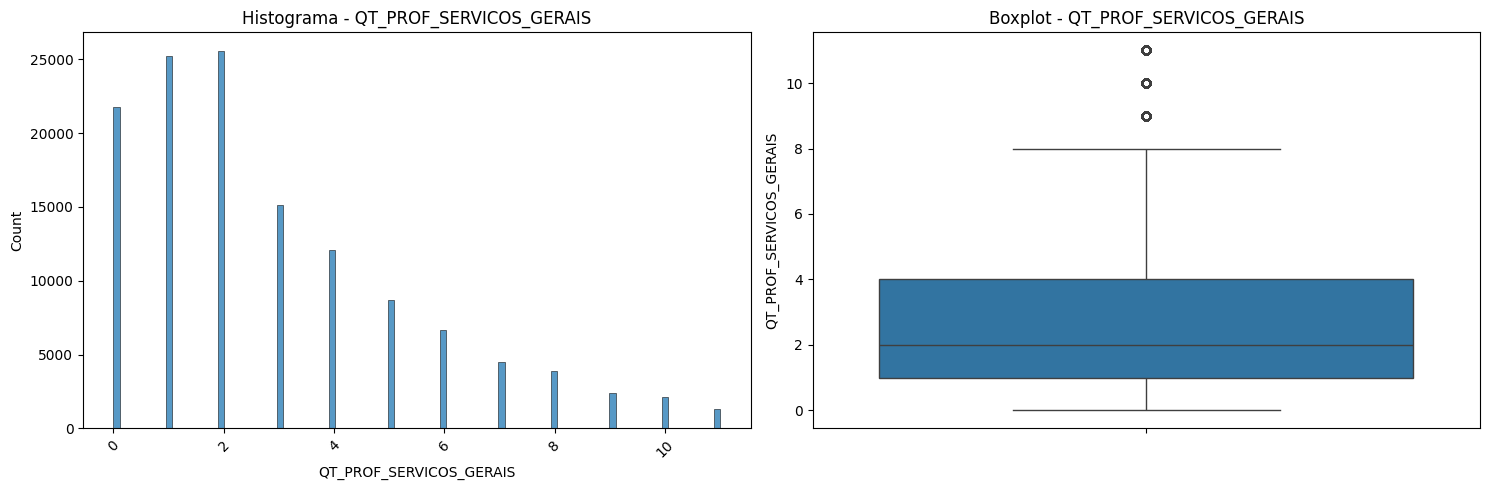

In [203]:
exibe_graficos_coluna(df_censo_eda, 'QT_PROF_SERVICOS_GERAIS')

In [ ]:
Explicar pq é aceitável

### QT_SALAS

In [199]:
qt_salas_cols = [col for col in df_censo_eda.columns if col.startswith('QT_SALAS')]

# Criar dataframe sem os outliers
df_sem_outliers, stats_remocao = tratar_outliers_iqr(
    df_censo_eda, 
    qt_salas_cols,
    estrategia='substituir',
    valor_substituicao='mediana',
    mostrar_stats=True
)

1. Total inicial: 129314

2. Colunas sendo analisadas:
['QT_SALAS_UTILIZADAS', 'QT_SALAS_UTILIZA_CLIMATIZADAS', 'QT_SALAS_UTILIZADAS_ACESSIVEIS']

3. Análise de outliers por coluna:

Coluna: QT_SALAS_UTILIZADAS
Q1: 4.00
Q3: 12.00
IQR: 8.00
Limite inferior: -8.00
Limite superior: 24.00
Número de outliers: 4110
Percentual de outliers: 3.18%

Coluna: QT_SALAS_UTILIZA_CLIMATIZADAS
Q1: 0.00
Q3: 4.00
IQR: 4.00
Limite inferior: -6.00
Limite superior: 10.00
Número de outliers: 13104
Percentual de outliers: 10.13%

Coluna: QT_SALAS_UTILIZADAS_ACESSIVEIS
Q1: 0.00
Q3: 2.00
IQR: 2.00
Limite inferior: -3.00
Limite superior: 5.00
Número de outliers: 21782
Percentual de outliers: 16.84%

4. Resultado final (Substituição):
Quantidade de registros: 129,314
Total de valores substituídos: 38,996
Percentual de valores substituídos: 10.05%

Método de substituição: mediana


In [200]:
# Exibir o resultado
print("\nResumo dos Outliers por Coluna:")
print("--------------------------------")
print(analise_outliers(df_sem_outliers))


Resumo dos Outliers por Coluna:
--------------------------------
                            Coluna  Total_Outliers  Percentual_Outliers  \
14   QT_SALAS_UTILIZA_CLIMATIZADAS           30602                23.66   
25                      QT_TUR_MED           28920                22.36   
7                        M_ATU_MED           28920                22.36   
26                         PIB_MUN           19855                15.35   
2                     TX_REPR_FUND           18998                14.69   
15  QT_SALAS_UTILIZADAS_ACESSIVEIS           17312                13.39   
0                    TX_APROV_FUND           14696                11.36   
8                      TX_DSU_FUND           14173                10.96   
28                       TX_EV_TOT           13932                10.77   
10                      M_HAU_FUND           11381                 8.80   
9                       TX_DSU_MED           10033                 7.76   
3                      TX_REPR_MED

Gerou mais outlier. O problema de gerar mais outliers após a substituição pela mediana pode ocorrer porque o IQR é recalculado após cada substituição, alterando os limites do que é considerado outlier. Portanto usar a estratégia de substituição pelos limites do IQR ('limite'),  pois é mais conservadora e evita distorcer a distribuição dos dados 


In [201]:
df_sem_outliers, stats_remocao = tratar_outliers_iqr(
    df_censo_eda, 
    qt_salas_cols,
    estrategia='substituir',
    valor_substituicao='limite',
    mostrar_stats=True
)

1. Total inicial: 129314

2. Colunas sendo analisadas:
['QT_SALAS_UTILIZADAS', 'QT_SALAS_UTILIZA_CLIMATIZADAS', 'QT_SALAS_UTILIZADAS_ACESSIVEIS']

3. Análise de outliers por coluna:

Coluna: QT_SALAS_UTILIZADAS
Q1: 4.00
Q3: 12.00
IQR: 8.00
Limite inferior: -8.00
Limite superior: 24.00
Número de outliers: 4110
Percentual de outliers: 3.18%

Coluna: QT_SALAS_UTILIZA_CLIMATIZADAS
Q1: 0.00
Q3: 4.00
IQR: 4.00
Limite inferior: -6.00
Limite superior: 10.00
Número de outliers: 13104
Percentual de outliers: 10.13%

Coluna: QT_SALAS_UTILIZADAS_ACESSIVEIS
Q1: 0.00
Q3: 2.00
IQR: 2.00
Limite inferior: -3.00
Limite superior: 5.00
Número de outliers: 21782
Percentual de outliers: 16.84%

4. Resultado final (Substituição):
Quantidade de registros: 129,314
Total de valores substituídos: 0
Percentual de valores substituídos: 0.00%

Método de substituição: limite


In [202]:
# Exibir o resultado
print("\nResumo dos Outliers por Coluna:")
print("--------------------------------")
print(analise_outliers(df_sem_outliers))


Resumo dos Outliers por Coluna:
--------------------------------
                            Coluna  Total_Outliers  Percentual_Outliers  \
7                        M_ATU_MED           28920                22.36   
25                      QT_TUR_MED           28920                22.36   
26                         PIB_MUN           19855                15.35   
2                     TX_REPR_FUND           18998                14.69   
0                    TX_APROV_FUND           14696                11.36   
8                      TX_DSU_FUND           14173                10.96   
28                       TX_EV_TOT           13932                10.77   
10                      M_HAU_FUND           11381                 8.80   
9                       TX_DSU_MED           10033                 7.76   
3                      TX_REPR_MED            9113                 7.05   
11                       M_HAU_MED            6664                 5.15   
1                     TX_APROV_MED